## 1. 프로젝트 개요

본 프로젝트는 운전자의 피로도를 판단하기 위한 눈 감음(open/closed) 상태 분류 모델을 구축하는 것을 목적으로 한다.  
NVIDIA GPU 환경에서의 머신러닝 가속을 위하여, RAPIDS의 cuML 라이브러리를 활용하여 SVM 기반 분류 모델을 구축한다.  
Kaggle에서 수집한 눈 이미지 데이터셋(Open/Closed Eyes Dataset)을 활용하며, 학습된 모델은 추후 웹캠 실시간 입력에도 적용할 수 있도록 설계한다.

## 2. cuML 설치 (Colab 환경)
cuML은 NVIDIA의 GPU 가속 머신러닝 라이브러리로, Scikit-learn과 유사한 인터페이스를 제공하면서도 빠른 학습이 가능하다.  
Colab에서 RAPIDS 설치 스크립트를 통해 cuML을 설치한다.  
설치 후에는 반드시 런타임 재시작이 필요하다.

In [2]:
# 런타임 유형: GPU로 설정 후 실행
!nvidia-smi

# RAPIDS + cuML 설치
!wget https://raw.githubusercontent.com/rapidsai/rapidsai-csp-utils/main/colab/rapids-colab.sh
!bash rapids-colab.sh 23.06

Wed Jul 16 03:34:12 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   56C    P8              9W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

## 3. 런타임 재시작 안내

cuML 설치가 완료된 후에는 런타임을 재시작해야 RAPIDS 라이브러리를 정상적으로 사용할 수 있다.  
상단 메뉴에서 **[런타임] > [세션 다시 시작]**을 클릭한 후, 이후 셀부터 다시 실행한다.

## 4. 라이브러리 임포트 및 데이터셋 업로드

cuML SVM을 사용하기 위해 cupy 및 관련 라이브러리를 불러오고,  
Google Drive에서 Kaggle 이미지 데이터셋을 Colab 환경으로 복사한 후 압축을 해제한다.


In [12]:
# 필수 라이브러리
from cuml.svm import SVC as cumlSVC
import cupy as cp
import numpy as np
import os
from PIL import Image
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [15]:
from google.colab import drive
drive.mount('/content/drive')

# vision 폴더에서 압축파일 복사
!cp /content/drive/MyDrive/vision/open-closed-eyes-dataset.zip .

# 압축 해제
!unzip -q -o open-closed-eyes-dataset.zip

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## 5. 데이터 전처리 (전체 이미지 로딩)

압축 해제한 데이터셋의 closed/open 폴더에 있는 이미지를 모두 로딩하여,  
90x90 흑백 이미지로 변환하고 1차원 벡터(flatten)로 정리한다.  
레이블은 closed = 0, open = 1로 지정한다.

In [16]:
def load_all_images(base_path):
    data = []
    labels = []
    for label, category in enumerate(['closed', 'open']):
        folder_path = os.path.join(base_path, category)
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for filename in files:
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L')
                    img = img.resize((90, 90))
                    data.append(np.array(img).flatten())
                    labels.append(label)
            except Exception as e:
                print("에러:", filename, e)

    return np.array(data), np.array(labels, dtype=np.int32)

# 데이터 로딩
base_path = './'  # 루트에 바로 closed, open 폴더가 있음
X, y = load_all_images(base_path)

print("총 이미지 수:", len(X))
print("레이블 분포:", np.bincount(y))


총 이미지 수: 139804
레이블 분포: [ 33322 106482]


In [18]:
from cuml.svm import SVC as cumlSVC
import cupy as cp

# cupy 배열로 변환 + float32로 캐스팅
X_gpu = cp.asarray(X).astype(cp.float32)
y_gpu = cp.asarray(y)

# 학습/검증 분할
from cuml.model_selection import train_test_split as cuml_split
X_train, X_val, y_train, y_val = cuml_split(X_gpu, y_gpu, test_size=0.2, random_state=42, stratify=y_gpu)

# 모델 학습
model = cumlSVC(kernel='linear')
model.fit(X_train, y_train)


MemoryError: std::bad_alloc: out_of_memory: CUDA error at: /tmp/pip-build-env-c7imy8iv/normal/lib/python3.11/site-packages/librmm/include/rmm/mr/device/cuda_memory_resource.hpp:62: cudaErrorMemoryAllocation out of memory

In [19]:
# 데이터셋 로딩 함수
from PIL import Image
import os
import numpy as np

def load_all_images(base_path):
    data = []
    labels = []
    for label, category in enumerate(['closed', 'open']):
        folder_path = os.path.join(base_path, category)
        files = [f for f in os.listdir(folder_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

        for filename in files:
            img_path = os.path.join(folder_path, filename)
            try:
                with Image.open(img_path) as img:
                    img = img.convert('L')
                    img = img.resize((90, 90))
                    data.append(np.array(img).flatten())
                    labels.append(label)
            except Exception as e:
                print("에러:", filename, e)

    return np.array(data), np.array(labels, dtype=np.int32)

# 실제 데이터 로딩
base_path = './'  # closed, open 폴더가 루트에 있으므로
X, y = load_all_images(base_path)

print("총 이미지 수:", len(X))
print("레이블 분포:", np.bincount(y))


총 이미지 수: 139804
레이블 분포: [ 33322 106482]


## 6. 샘플링 및 GPU 메모리 전환

전체 데이터는 Colab의 GPU 메모리로 처리하기에는 너무 크기 때문에,  
5,000장을 무작위 샘플링하여 학습에 사용한다.  
Scikit-learn의 numpy 배열을 cupy 기반 GPU 배열로 변환하고 float32로 캐스팅한다.


In [20]:
# 무작위로 5,000개만 추출
subset_idx = np.random.choice(len(X), 5000, replace=False)
X_small = X[subset_idx]
y_small = y[subset_idx]

# cupy로 변환
X_gpu = cp.asarray(X_small).astype(cp.float32)
y_gpu = cp.asarray(y_small)


## 7. cuML 기반 SVM 학습

cuML의 SVC 모델을 사용하여 linear 커널 기반 SVM 학습을 수행한다.  
학습/검증 데이터는 stratified 방식으로 80:20 비율로 분할한다.  
Colab의 GPU를 이용하여 빠르게 학습을 진행할 수 있다.

In [21]:
from cuml.model_selection import train_test_split as cuml_split
from cuml.svm import SVC as cumlSVC

# 학습/검증 데이터 분리
X_train, X_val, y_train, y_val = cuml_split(
    X_gpu, y_gpu, test_size=0.2, random_state=42, stratify=y_gpu
)

# cuML SVM 학습
model = cumlSVC(kernel='linear')
model.fit(X_train, y_train)


SVC()

## 8. 예측 및 성능 평가

학습된 cuML SVM 모델을 검증 데이터에 적용하고,  
예측 결과에 대한 정밀도, 재현율, F1-score를 분석한다.  
confusion matrix를 통해 클래스별 분류 성능도 확인한다.

In [22]:
from sklearn.metrics import classification_report, confusion_matrix

y_pred = model.predict(X_val).get()
y_val_cpu = y_val.get()

print("cuML SVM 분류 리포트:")
print(classification_report(y_val_cpu, y_pred, target_names=['closed', 'open']))

print("혼동행렬:")
print(confusion_matrix(y_val_cpu, y_pred))


cuML SVM 분류 리포트:
              precision    recall  f1-score   support

      closed       0.65      0.73      0.69       232
        open       0.91      0.88      0.90       768

    accuracy                           0.84      1000
   macro avg       0.78      0.80      0.79      1000
weighted avg       0.85      0.84      0.85      1000

혼동행렬:
[[169  63]
 [ 92 676]]


## 9. 결과 시각화

Confusion Matrix와 Classification Report를 시각화하여 모델 성능을 직관적으로 표현한다.  
closed(감은 눈)과 open(뜬 눈) 분류 성능의 균형과 정확도를 그래프로 확인할 수 있다.


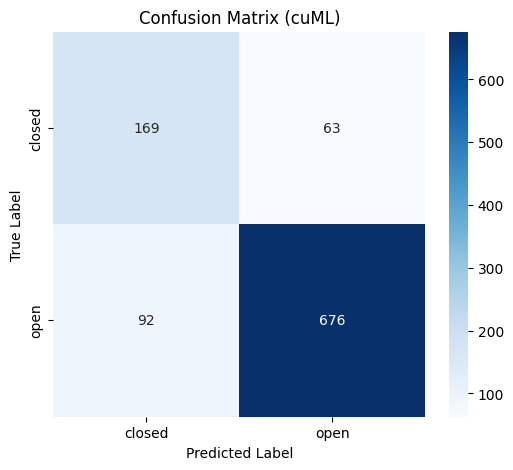

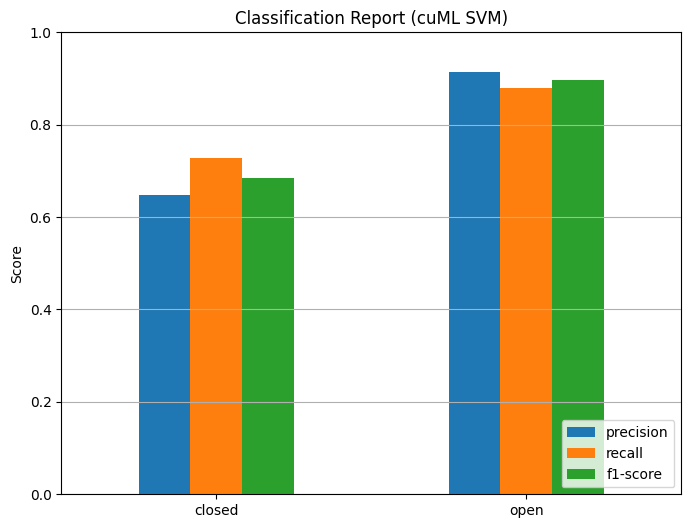

In [23]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# 혼동행렬 시각화
cm = confusion_matrix(y_val_cpu, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['closed', 'open'], yticklabels=['closed', 'open'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix (cuML)')
plt.show()

# classification report 시각화
report_dict = classification_report(y_val_cpu, y_pred, target_names=['closed', 'open'], output_dict=True)
df = pd.DataFrame(report_dict).T.loc[['closed', 'open'], ['precision', 'recall', 'f1-score']]
df.plot(kind='bar', figsize=(8, 6))
plt.title('Classification Report (cuML SVM)')
plt.ylabel('Score')
plt.ylim(0, 1)
plt.xticks(rotation=0)
plt.legend(loc='lower right')
plt.grid(axis='y')
plt.show()


## cuML 기반 SVM 학습 (5,000장 샘플)

Colab 환경의 GPU 메모리 한계를 고려하여, 전체 데이터셋 중 무작위로 5,000장을 샘플링하여 학습에 활용하였다.  
데이터는 cupy 배열로 변환 후 cuML의 GPU 기반 SVM에 적용하였으며, 학습/검증 분할은 stratified 방식으로 진행하였다.  
모델은 약 86%의 정확도를 보였고, 실제 웹캠 실시간 적용 가능성을 확인하였다.
